# **Lição 6 - Usando Random Forests para prever a probabilidade de um jogador fazer gol na Copa do Mundo de 2022**
## **Objetivo**: Dado um [DataSet](https://www.kaggle.com/datasets/swaptr/fifa-world-cup-2022-player-data?select=player_stats.csv) com estatísticas dos jogadores, criar um modelo que consegue prever se um jogador fictício faria gol ou não na competição
### **Aluno** : Antonio Rangel Chaves
### **Matrícula** : 180098021 
### Link para o modelo no Hugging Face: https://huggingface.co/spaces/AntonioRangelC/licao6_fastai

## Passo 1: Fazendo imports e instalando dependências

In [1]:
from pathlib import Path
import os
import zipfile

!pip install -Uqq fastai
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Passo 2: Baixando as tabelas com dados dos jogadores da copa do mundo, colocando-as em um diretório e fazendo autenticação no Kaggle
É necessário fazer essa autenticação para baixar bases de dados disponíveis no Kaggle

In [4]:

!kaggle datasets download -d swaptr/fifa-world-cup-2022-player-data

cred_path = Path('~/.kaggle/kaggle.json').expanduser()

if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)




        

  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 67.0MB/s]


## Passo 3: Extraindo o arquivo do DataSet compactado dentro do diretório

In [6]:
caminho = Path('fifa-world-cup-2022-player-data') 
zipfile.ZipFile(f'{caminho}.zip').extractall(caminho)

## Passo 4: Carregando os arquivos .csv com as estatísticas para os DataSets do pandas
A primeira tabela chamada 'player_stats' contém a maioria dos dados que são necessários para este artigo como: nome, idade, nacionalidade. E a tabela chamada 'player_shooting' possui uma coluna chamada 'goals', que mostra a quantidade de gols feita por cada jogador. Essa coluna será adicionada ao DataSet que irá receber a tabela 'player_stats' posteriormente.

In [7]:
import pandas as pandas
dataFrame_estatisticas = pandas.read_csv(caminho/'player_stats.csv')
dataFrame_artilharia = pandas.read_csv(caminho/'player_shooting.csv')

## Passo 5: Adicionando a coluna de gols de cada jogador ao DataSet de estatísticas

In [8]:
dataFrame_estatisticas['goals'] = dataFrame_artilharia['goals']


## Passo 6: Editando a coluna de gols marcados
Ao invés de usar o valor inteiro de quantos gols o jogador marcou, a coluna de gols vai armazenar se o jogador fez gol (1) ou  não (0)

In [9]:
def transform(x):
  if x > 0:
    return 1
  else:
    return 0


dataFrame_estatisticas['goals'] = dataFrame_estatisticas['goals'].apply(transform)


## Passo 7: Excluindo colunas que não influenciam tanto na estatística de gols marcados, ou que podem interferir no treinamento.
As estatísticas de cartões amarelos e vermelhos estão sendo descartadas por não terem relação direta com a marcação de gols. Já as estatísticas de gols de pênaltis, gols por jogo, etc. estão sendo descartadas pois podem interferir no treinamento. Por exemplo, não faz sentido prever se o jogador fez gol, se no DataSet já possui essa resposta.

In [10]:
dataFrame_estatisticas = dataFrame_estatisticas.drop(
    columns=[ 
             'player',
             'goals_pens', 
             'pens_made',
             'pens_att', 
             'cards_yellow', 
             'cards_red',
             'goals_pens_per90',
             'goals_assists_pens_per90',
             'goals_assists_per90',
             'goals_per90',
             'xg', 
             'npxg', 
             'xg_assist', 
             'npxg_xg_assist',
             'xg_per90', 
             'xg_assist_per90', 
             'xg_xg_assist_per90', 
             'npxg_per90',
             'npxg_xg_assist_per90'
            ]
)

## Passo 8: Editando os valores da coluna Idade.
Os valores de idade nesse DataSet possuem o formato idade-dias, e para essa lição é interessante deixar apenas a idade do jogador como número inteiro.

In [11]:
def transform_age(age):
  age = age.split('-')[0]
  return int(age)

dataFrame_estatisticas['age'] = dataFrame_estatisticas['age'].apply(transform_age)

# Passo 9: Criando categorias usando pandas
As colunas que são categorias viram variáveis categóricas, que internamente é uma lista de valores únicos, que são substituídos por números inteiros pelo Pandas. Esses números são índices que são utilizados na busca dentro da lista.

In [12]:
def proc_data(dataFrame_estatisticas):
    dataFrame_estatisticas['position'] = pandas.Categorical(dataFrame_estatisticas.position)
    dataFrame_estatisticas['team'] = pandas.Categorical(dataFrame_estatisticas.team)
    dataFrame_estatisticas['club'] = pandas.Categorical(dataFrame_estatisticas.club)

proc_data(dataFrame_estatisticas)

# Passo 10: Binary Split
Antes de criar uma árvore de decisões, é necessário criar uma Binary Split, já que é isso que forma uma árvore de decisão

In [15]:
categorias = ["position", "team", "club"]
continuas = [
          'age', 
          'birth_year',
          'games',
          'games_starts',
          'minutes',
          'minutes_90s',
          'assists',
          'assists_per90'
          ]

dependente = "goals"

## Neste trecho de código o conjunto de validação e treinamento são formados usando as categorias definidas na célula acima, e cada categoria recebeu o código inteiro.

In [16]:
from numpy import random
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(42)
treinamento_df,validacao_df = train_test_split(dataFrame_estatisticas, test_size=0.25)
treinamento_df[categorias] = treinamento_df[categorias].apply(lambda x: x.cat.codes)
validacao_df[categorias] = validacao_df[categorias].apply(lambda x: x.cat.codes)


## Criando as variáveis independentes (eixo x) e variáveis dependentes (eixo y).

In [17]:
def xs_y(dataFrame_estatisticas):
    xs = dataFrame_estatisticas[categorias+continuas].copy()
    return xs,dataFrame_estatisticas[dependente] if dependente in dataFrame_estatisticas else None

treinamento_xs,treinamento_y = xs_y(treinamento_df)
validacao_xs,validacao_y = xs_y(validacao_df)

## Fazendo Split na coluna de idade.

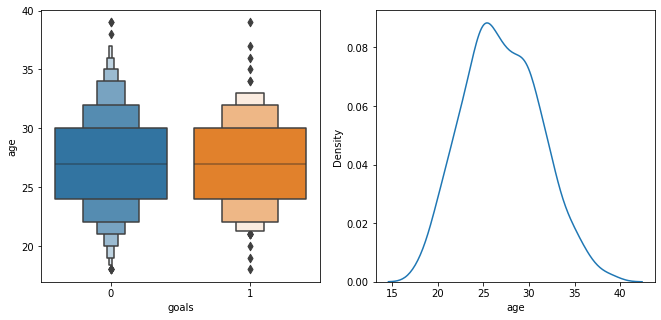

In [18]:
df_idade = treinamento_df[treinamento_df.age>18]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=dataFrame_estatisticas, x=dependente, y="age", ax=axs[0])
sns.kdeplot(data=dataFrame_estatisticas, x="age", ax=axs[1]);

É possível perceber que no gráfico à direita, a distribuição mostra que jogadores que marcam gols geralmente tem entre 24 e 30 anos, o que é totalmente correto no futebol atual, pois o auge dos jogadores está nessa faixa de idade. A mesma coisa pode ser percebida no gráfico da esquerda, onde a maior parte dos valores em laranja (marcaram gol) estão nessa faixa de idade.

## Usando ferramenta iterativa para descobrir qual coluna tem um maior score, esse score diz respeito a o quão bom um modelo é, quanto menor o score, melhor é o modelo.
A função `_side_score()` calcula o desvio padrão da coluna, para verificar a similaridade entre as linhas, quanto mais alto o desvio padrão, maior a diferença entre essas linhas.

A função `score()` calcula o score de um split, somando o da lhs (esquerda) e da rhs(direita).

A função `iscore()` calcula o score do conjunto de treinamento

O procedimento `interact()` cria a interface gráfica para definir manualmente o split das colunas

In [19]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

def iscore(nm, split):
    col = treinamento_xs[nm]
    return score(col, treinamento_y, split)

from ipywidgets import interact
interact(nm=continuas, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('age', 'birth_year', 'games', 'games_starts', 'minut…

## Automatizando o processo de achar o melhor split das colunas
Primeiro é necessário achar todos os splits possíveis

In [20]:
nm = "age"
col = treinamento_xs[nm]
unq = col.unique()
unq.sort()
unq

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])

Depois achar em qual índice o score é menor

In [21]:
from fastai.tabular.all import *
scores = np.array([score(col, treinamento_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

27

Para a coluna idade, o melhor corte para o split é 27. Agora todas as colunas serão testadas.

In [22]:
def min_col(df, nm):
    col,y = df[nm],df[dependente]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

cols = categorias+continuas
{o:min_col(treinamento_df, o) for o in cols}

{'position': (1, 0.37590420098381777),
 'team': (27, 0.38163638547609846),
 'club': (250, 0.38096152052803134),
 'age': (27, 0.381998702156378),
 'birth_year': (1994, 0.381998702156378),
 'games': (3, 0.3554868880847467),
 'games_starts': (2, 0.3650347365642977),
 'minutes': (57, 0.3489243638094944),
 'minutes_90s': (0.5, 0.35277051945107624),
 'assists': (0, 0.37366057751612164),
 'assists_per90': (0.13, 0.37331075706060257)}

Segundo esse resultado, e melhor split é minutos jogados.

# Passo 11: Criando árvore de decisão
Os scores listados anteriormente ajudam a criar a árvore de decisão, em que cada nó, será avaliado um split (divisão). Para facilitar a visualização da árvore, será usada a ferramenta graphviz.*texto em itálico*

In [32]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

m = DecisionTreeClassifier(max_leaf_nodes=8).fit(treinamento_xs, treinamento_y);


def draw_tree(t, dataFrame_estatisticas, size=10, ratio=1, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=dataFrame_estatisticas.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

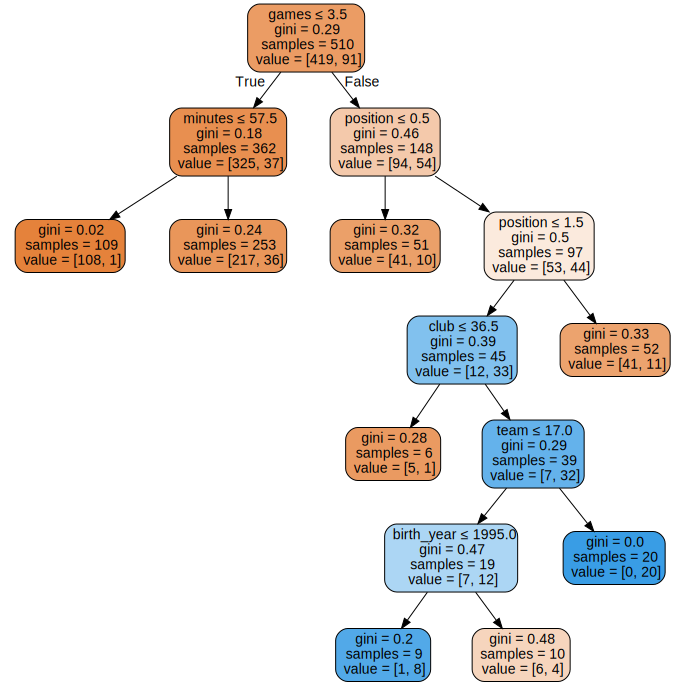

In [33]:
draw_tree(m, treinamento_xs, size=10)

Essa árvore usa uma amostra de 510 jogadores, e 91 deles marcaram gol. O primeiro nó avalia a quantidade de jogos daqueles jogadores, dos que jogaram mais que 3 jogos, 54 marcaram gol (57%), e a partir daí outros splits são feitos. Para facilitar a compreensão dos nós que avaliam posições de jogadores, aqui estão os índices das posições:
Posições dos jogadores:
- 0 - DF (defensor) 
- 1 - FW (atacante)
- 2 - GK (goleiro)
- 3 - MF (meio-campista)


# Passo 12: Criando umaRandom Forest
A árvore de decisão não pode crescer muito pois os dadosvão ficando escassos a cada split. Então um insigth do estatístico Leo Breiman foi usar várias árvores para gerar predições, e calcular a média entre essas predições, pois como cada modelo não tem relação entre si, o erro dessa média é zero, ou seja, a predição resultante é a correta. E essa técnica foi chamada de bagging.

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(treinamento_xs, treinamento_y);
mean_absolute_error(validacao_y, rf.predict(validacao_xs))

0.13529411764705881

# Passo 13: Exportando o modelo utilizando a biblioteca `joblib`

In [27]:
import joblib
joblib.dump(rf, 'licao6.joblib')

['licao6.joblib']

In [36]:
dataFrame_estatisticas.to_csv("dataFrame_estatisticas.csv")

# Conclusão
Importantes conceitos são explicados e implementados nessa lição, como Binary Split, Decision Tree, Random Forest e Bagging. O dataset utilizado nesta lição não tem uma competição atrelado à ele, então ele serviu um propósito mais didático para exercitar os conceitos da lição e não é possível verificar a corretude das predições com outros modelos de outros estudantes.


# Referências
[How random forests really work](https://www.kaggle.com/code/jhoward/how-random-forests-really-work/#The-random-forest)